In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

def scrape_dir_page():
    # Initialize empty lists where scrapped data will be stored
    titles = []
    links = []
    date_posted = []
    tags = []
    page_num = 1

    # While loop to iterate through all pages in the infinite scroll. Break on a 404 error
    while (True): 
        dir_url = 'https://scrapsfromtheloft.com/tag/stand-up-transcripts/' + 'page/' + str(page_num)

        # Request page content
        dir_page_response = requests.get(dir_url, timeout=120)
        
        # Exit loop when we run out of pages and get a 404 error
        if (dir_page_response.status_code == 404):
            print(f'Total pages scraped before error: {page_num - 1}')
            break 
        else:
            # Parse and turn into soup
            dir_page_soup = BeautifulSoup(dir_page_response.content, 'html.parser')
            # Take title-cards as containers
            dir_containers = dir_page_soup.find_all('div', attrs={'class':'fusion-post-content post-content'}) 

            # Strip titles, links, posting dates, and tags from each card
            for i in dir_containers:
                titles.append(i.h2.text)
                links.append(i.a['href'])
                # Posted date is the 4th span item (index 3)
                date_posted.append(i.select('span')[3].get_text()) 
                # Tags are the 7th span item. The first 6 characters appearing in each one is "tags: ", so those are skipped with [5:]
                tags.append(i.select('span')[6].get_text(strip=True)[5:]) 
            page_num += 1     
    return titles, links, date_posted, tags

titles, links, date_posted, tags = scrape_dir_page()

# Create a DataFrame object with data lists
df = pd.DataFrame({'title': titles,
                  'tags': tags,
                   'date_posted':date_posted,
                   'link': links})

print(f'Length : {len(df)}')

df.head()

Total pages scraped before error: 16
Length : 314


,title,tags,date_posted,link
0,Chris D’Elia: Man on Fire (2017) – Full Transc...,"Chris D'Elia,Stand-up transcripts","April 19th, 2020",https://scrapsfromtheloft.com/2020/04/19/chris...
1,George Carlin: The Indian Drill Sergeant – Tra...,"George Carlin,Stand-up transcripts","April 13th, 2020",https://scrapsfromtheloft.com/2020/04/13/georg...
2,Tom Segura: Ball Hog (2020) – Full Transcript,"Stand-up transcripts,Tom Segura","March 25th, 2020",https://scrapsfromtheloft.com/2020/03/25/tom-s...
3,Bert Kreischer: Hey Big Boy (2020) – Full Tran...,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...
4,Bert Kreischer: Fighting a Bear [Transcript],"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...


In [2]:
def names_from_tags(tag_series):
    # Irrelevant tags to remove in order to render names
    remove_tags = ['Stand-up transcripts', 'Gun control', 'SATURDAY NIGHT LIVE', 'Abortion', 'Religion', ',']
    for tag in remove_tags:
        tag_series = tag_series.str.replace(tag, '')
    name_series = tag_series[tag_series.apply(lambda x: len(x) < 30)]
    return name_series

df['name'] = names_from_tags(df.tags)

df.head()

,title,tags,date_posted,link,name
0,Chris D’Elia: Man on Fire (2017) – Full Transc...,"Chris D'Elia,Stand-up transcripts","April 19th, 2020",https://scrapsfromtheloft.com/2020/04/19/chris...,Chris D'Elia
1,George Carlin: The Indian Drill Sergeant – Tra...,"George Carlin,Stand-up transcripts","April 13th, 2020",https://scrapsfromtheloft.com/2020/04/13/georg...,George Carlin
2,Tom Segura: Ball Hog (2020) – Full Transcript,"Stand-up transcripts,Tom Segura","March 25th, 2020",https://scrapsfromtheloft.com/2020/03/25/tom-s...,Tom Segura
3,Bert Kreischer: Hey Big Boy (2020) – Full Tran...,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer
4,Bert Kreischer: Fighting a Bear [Transcript],"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer


In [3]:
import re

# Processing raw_title to get year 
def year_from_title(raw_title_series):
    # Regex search for 4 digits in a row
    years = raw_title_series.apply(lambda x: re.findall(r"(\d{4})", x))
    series_dict = years.to_dict()
    for key in series_dict:
        if not series_dict[key]:
            series_dict[key] = np.nan
        else:
            series_dict[key] = series_dict[key][0]
    return pd.Series(series_dict)
            
df['year'] = year_from_title(df.title)

df.head()

,title,tags,date_posted,link,name,year
0,Chris D’Elia: Man on Fire (2017) – Full Transc...,"Chris D'Elia,Stand-up transcripts","April 19th, 2020",https://scrapsfromtheloft.com/2020/04/19/chris...,Chris D'Elia,2017
1,George Carlin: The Indian Drill Sergeant – Tra...,"George Carlin,Stand-up transcripts","April 13th, 2020",https://scrapsfromtheloft.com/2020/04/13/georg...,George Carlin,NaN
2,Tom Segura: Ball Hog (2020) – Full Transcript,"Stand-up transcripts,Tom Segura","March 25th, 2020",https://scrapsfromtheloft.com/2020/03/25/tom-s...,Tom Segura,2020
3,Bert Kreischer: Hey Big Boy (2020) – Full Tran...,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,2020
4,Bert Kreischer: Fighting a Bear [Transcript],"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,NaN


In [4]:
def clean_titles(title_series):
    # Remove everything between parentheses (year)
    title_series = title_series.apply(lambda x: re.sub('\(.*?\)', '', x))
    # Remove all other extraneous text from titles
    remove_list = ['-', '–', 'Transcript', 'transcript', 'Full', 'full', '[', ']', ]
    for i in remove_list:
        title_series = title_series.apply(lambda x: x.replace(i, ''))
    return title_series

df.title = clean_titles(df.title)

df.head()

,title,tags,date_posted,link,name,year
0,Chris D’Elia: Man on Fire,"Chris D'Elia,Stand-up transcripts","April 19th, 2020",https://scrapsfromtheloft.com/2020/04/19/chris...,Chris D'Elia,2017
1,George Carlin: The Indian Drill Sergeant,"George Carlin,Stand-up transcripts","April 13th, 2020",https://scrapsfromtheloft.com/2020/04/13/georg...,George Carlin,NaN
2,Tom Segura: Ball Hog,"Stand-up transcripts,Tom Segura","March 25th, 2020",https://scrapsfromtheloft.com/2020/03/25/tom-s...,Tom Segura,2020
3,Bert Kreischer: Hey Big Boy,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,2020
4,Bert Kreischer: Fighting a Bear,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,NaN


In [5]:
# Use links from  directory page to scrape each individual stand-up special's page

def scrape_transcript_page(url):
    # Request transcript page content
    transcript_page_response = requests.get(url, timeout=120)
    # Parse and turn into soup
    transcript_page_soup = BeautifulSoup(transcript_page_response.content, 'html.parser')
    # Pull text from each p into a list
    text_list = [p.text for p in transcript_page_soup.find(attrs={'class':'post-content'}).find_all('p')]
    combined_text = ' '.join(text_list)
    return combined_text

def clean_text(full_text):
    # Remove text between brackets (like "[whistling]", "[crowd laughing]" etc...)
    full_text = re.sub('\[.*?\]', '', full_text)
    # Remove brackets, quotes, and elipses
    full_text = re.sub('[♪)(‘’“”…]', '', full_text)
    # Remove line breaks \n
    full_text = re.sub('\n', '', full_text)
    # Remove numbers
    full_text = re.sub('\w*\d\w*', '', full_text)
    # Remove extra space
    full_text = re.sub('  ', ' ', full_text)
    return full_text

def get_clean_transcripts(links):
    transcripts = []
    count = 0
    # Iterate through links and try to get a transcription
    for i in links:
        count+=1
        try:
            transcripts.append(scrape_transcript_page(i))
        except:
            transcripts.append('')
            print(f"Transcription with error, index: {count}")
    cleaned_transcripts = []
    for i in transcripts:
        cleaned_transcripts.append(clean_text(i))
    return pd.Series(cleaned_transcripts)

df['transcript'] = get_clean_transcripts(df.link)

df.head()

Transcription with error, index: 40
Transcription with error, index: 41


,title,tags,date_posted,link,name,year,transcript
0,Chris D’Elia: Man on Fire,"Chris D'Elia,Stand-up transcripts","April 19th, 2020",https://scrapsfromtheloft.com/2020/04/19/chris...,Chris D'Elia,2017,Fire Fire Man on fire Fire Fire Fire Man on ...
1,George Carlin: The Indian Drill Sergeant,"George Carlin,Stand-up transcripts","April 13th, 2020",https://scrapsfromtheloft.com/2020/04/13/georg...,George Carlin,NaN,"In The Indian Sergeant, was emerging as George..."
2,Tom Segura: Ball Hog,"Stand-up transcripts,Tom Segura","March 25th, 2020",https://scrapsfromtheloft.com/2020/03/25/tom-s...,Tom Segura,2020,"How you doing? No shit. Thank you, thank you..."
3,Bert Kreischer: Hey Big Boy,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,2020,Ladies and gentlemen Bert Kreischer! Yeah! Wh...
4,Bert Kreischer: Fighting a Bear,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,NaN,"The machine, Mr. Bert Kreischer, everybody. Le..."


In [6]:
# Get indices for which transcripts are empty
dop_indices = df[df.transcript == ''].index

# Checkout these rows to make sure we really want to drop them
for i in dop_indices:
    print(df.iloc[i], '\n')

title                  Protected: Katherine Ryan: In Trouble    
tags                         Katherine Ryan,Stand-up transcripts
date_posted                                       July 6th, 2019
link           https://scrapsfromtheloft.com/2019/07/06/kathe...
name                                              Katherine Ryan
year                                                        2017
transcript                                                      
Name: 39, dtype: object 

title                Protected: Katherine Ryan: Glitter Room    
tags                         Katherine Ryan,Stand-up transcripts
date_posted                                       July 5th, 2019
link           https://scrapsfromtheloft.com/2019/07/05/kathe...
name                                              Katherine Ryan
year                                                        2019
transcript                                                      
Name: 40, dtype: object 



In [7]:
# Delete these row indices from the DataFrame, report changes
old_len = len(df)
print('Length before dropping rows with null values for transcripts: ', old_len)
df.drop(dop_indices , inplace=True)
df = df.reset_index(drop=True)
new_len = len(df)
print('After drops: ', new_len)
print('Deleted: ', old_len - new_len)

Length before dropping rows with null values for transcripts:  314
After drops:  312
Deleted:  2


In [ ]:
from langdetect import detect

# Dectect language based on the first 500 characters and create a language column in the df
df['language'] = df.transcript.apply(lambda x: detect(x[:500]))

df.head()

In [12]:
import imdb

imdb = imdb.IMDb()

def get_imdb_info(titles):
    runtime = []
    rating = []
    count = -1
    errors = 0
    
    for i in titles:
        count += 1
        # Search the first 30 characters on IMDb
        result = imdb.search_movie(i[:30])
        try:
            mov = imdb.get_movie(result[0].movieID, info=['main'])
            runtime.append(mov.get('runtimes')[0])
            rating.append(mov.get('rating'))
        except:
            runtime.append('')
            rating.append('')
            errors += 1
            # print(f'Error on index {count}, title: {i}') # Uncomment to investigate which  titles were not found
    print(f'Total not found: {errors}')
    return pd.Series(runtime), pd.Series(rating)
    
runtime, rating = get_imdb_info(df.title)

df['runtime'] = runtime
df['rating'] = rating

df.head()

Total not found: 46


,title,tags,date_posted,link,name,year,transcript,language,runtime,rating
0,Chris D’Elia: Man on Fire,"Chris D'Elia,Stand-up transcripts","April 19th, 2020",https://scrapsfromtheloft.com/2020/04/19/chris...,Chris D'Elia,2017,Fire Fire Man on fire Fire Fire Fire Man on ...,en,65,6.6
1,George Carlin: The Indian Drill Sergeant,"George Carlin,Stand-up transcripts","April 13th, 2020",https://scrapsfromtheloft.com/2020/04/13/georg...,George Carlin,NaN,"In The Indian Sergeant, was emerging as George...",en,,
2,Tom Segura: Ball Hog,"Stand-up transcripts,Tom Segura","March 25th, 2020",https://scrapsfromtheloft.com/2020/03/25/tom-s...,Tom Segura,2020,"How you doing? No shit. Thank you, thank you...",en,70,7.3
3,Bert Kreischer: Hey Big Boy,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,2020,Ladies and gentlemen Bert Kreischer! Yeah! Wh...,en,62,7.1
4,Bert Kreischer: Fighting a Bear,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,NaN,"The machine, Mr. Bert Kreischer, everybody. Le...",en,,


In [13]:
# Save DataFrame to the current drectory
df.to_csv(r'./StandUpData.csv', index=False)

In [1]:
# Load df from csv
import pandas as pd
df = pd.read_csv('StandUpData.csv')
df.head()

,title,tags,date_posted,link,name,year,transcript,language,runtime,rating
0,Chris D’Elia: Man on Fire,"Chris D'Elia,Stand-up transcripts","April 19th, 2020",https://scrapsfromtheloft.com/2020/04/19/chris...,Chris D'Elia,2017.0,Fire Fire Man on fire Fire Fire Fire Man on ...,en,65.0,6.6
1,George Carlin: The Indian Drill Sergeant,"George Carlin,Stand-up transcripts","April 13th, 2020",https://scrapsfromtheloft.com/2020/04/13/georg...,George Carlin,NaN,"In The Indian Sergeant, was emerging as George...",en,NaN,NaN
2,Tom Segura: Ball Hog,"Stand-up transcripts,Tom Segura","March 25th, 2020",https://scrapsfromtheloft.com/2020/03/25/tom-s...,Tom Segura,2020.0,"How you doing? No shit. Thank you, thank you...",en,70.0,7.3
3,Bert Kreischer: Hey Big Boy,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,2020.0,Ladies and gentlemen Bert Kreischer! Yeah! Wh...,en,62.0,7.1
4,Bert Kreischer: Fighting a Bear,"Bert Kreischer,Stand-up transcripts","March 21st, 2020",https://scrapsfromtheloft.com/2020/03/21/bert-...,Bert Kreischer,NaN,"The machine, Mr. Bert Kreischer, everybody. Le...",en,NaN,NaN


Mean: 42316.6858974359
SD: 16981.740741917434


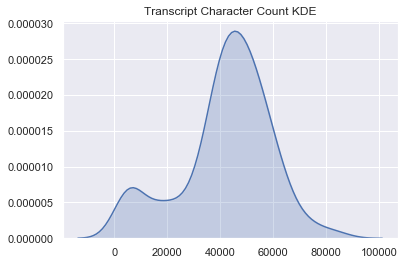

In [10]:
import numpy as np
import seaborn as sns; sns.set(color_codes=True)

# Stats and KDE plot for character count of each transcript
x = [len(x) for x in df.transcript]
ax = sns.kdeplot(x, shade=True, color="b")
ax.set_title('Transcript Character Count KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 68.04887218045113
SD: 15.241460651399967


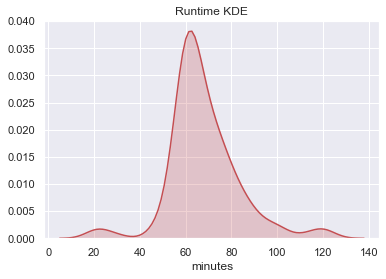

In [5]:
# Stats and KDE plot for runtime of each performance
x = []
count = 0
for i in df.runtime:
    if (i > 0):
        count += 1
        x.append(int(i))
ax = sns.kdeplot(x, shade=True, color="r")   
ax.set_title('Runtime KDE')
ax.set(xlabel='minutes')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')

Mean: 7.33421052631579
SD: 0.9058263460578438


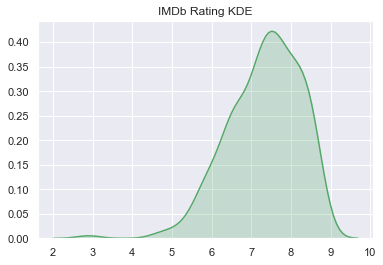

In [11]:
# Stats and KDE plot for IMDb rating of each performance
x = []
count = 0
for i in df.rating:
    if (i > 0):
        count += 1
        x.append(i)
ax = sns.kdeplot(x, shade=True, color="g")   
ax.set_title('IMDb Rating KDE')
mean = np.array(x).mean()
sd = np.array(x).std()
print(f'Mean: {mean}')
print(f'SD: {sd}')